---

# Predicting Financial Distress with Logistic Regression

In this notebook, we will use logistic regression to predict whether an individual is likely to experience serious financial distress within the next two years, based on their financial profile. Logistic regression models the log-odds of a binary outcome as a linear function of the input features, and it is commonly used in credit scoring, fraud detection, and risk assessment due to its simplicity and interpretability.

The Give Me Some Credit dataset provides anonymized financial and demographic information for thousands of individuals. The target variable, SeriousDlqin2yrs, indicates whether a person has been delinquent for 90 days or more on a credit account in the past two years.

We will preprocess the data, train a logistic regression classifier, evaluate its performance, and interpret the learned coefficients to understand how different factors contribute to financial risk.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve


---

Load in our dataframe.

---

In [4]:
df = pd.read_csv("data/cs-training.csv", index_col=0)
df.rename(columns={'SeriousDlqin2yrs': 'Distress'}, inplace=True)
df

,Distress,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


---

Process our data by removing empty rows and separating features from targets.

---

In [ ]:
df.dropna(inplace=True)  # Drop rows with missing values

# Define features and target
X = df.drop(columns='Distress')
y = df['Distress']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

---

Split the data into training and testing.

---

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

---

Train our regressor over 1000 iterations on the training data.

---

In [8]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

---

Let's evaluate the performance of our model! Here, we can print the confusion matrix and the accuracy of our model.

---

Accuracy: 93.13%

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     22383
           1       0.58      0.04      0.07      1671

    accuracy                           0.93     24054
   macro avg       0.76      0.52      0.52     24054
weighted avg       0.91      0.93      0.90     24054



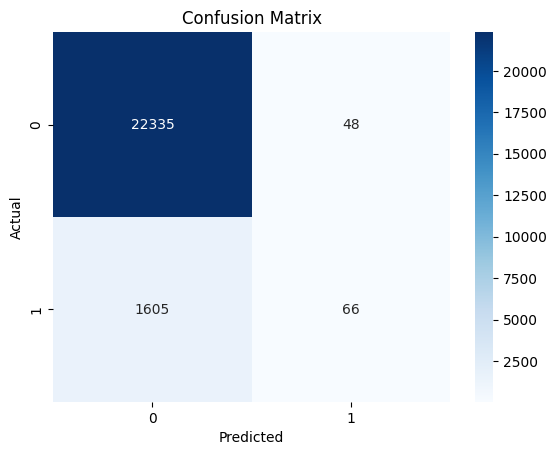

In [9]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For AUC and ROC

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

---

Our model is very accurate! We may be concerned that it seems to overpredict for category 0 in most cases, but we can also look at this as avoidance of overfitting. In the future, we could cross-reference with other test sets to verify for sure. For now, we can graph the area under the ROC curve to contextualize the accuracy of our model.

---

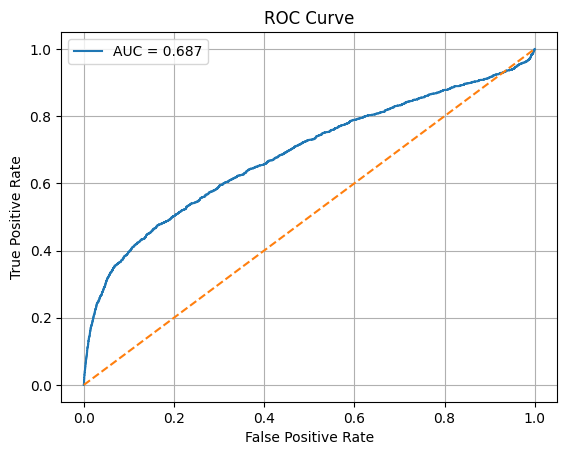

In [11]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

---

The model can correctly rank a truly distressed borrower higher than a non-distressed one about 68% of the time. This suggests the logistic regression captures meaningful patterns, though there's room for improvement, perhaps via more features or regularization. Like we did with linear regression, we can also view the relative weights of different feature coefficients.

---

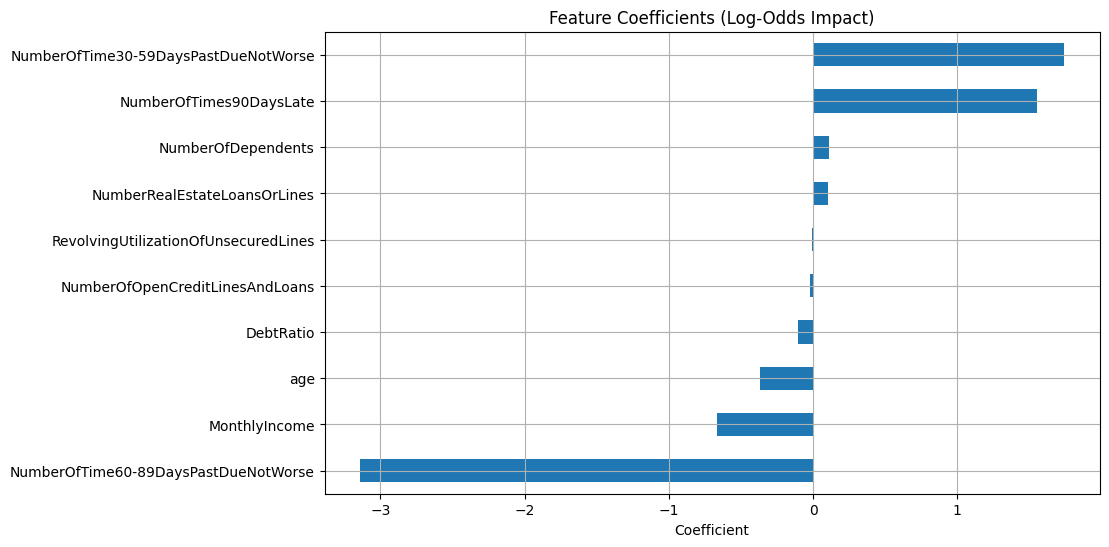

In [12]:
coefs = pd.Series(model.coef_[0], index=df.columns.drop('Distress'))
coefs.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title("Feature Coefficients (Log-Odds Impact)")
plt.xlabel("Coefficient")
plt.grid(True)
plt.show()

---

We can see why logistic regression is such a powerful technique! It was able to generate comparable results to KNN in mere fractions of the training time for such a large dataset, making it very useful and convenient in real-world situations.

---